<a href="https://colab.research.google.com/github/DayenaJeong/FS_neuron/blob/main/FS_conversion_uniform_softplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [10]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        if num_params == 4:
            h = torch.tensor([4.4682, 4.2097, 0.5166, 0.4746])
            d = torch.tensor([4.2236, 4.1465, 1.3406, 1.4113])
            T = torch.tensor([3.4595, 3.2402, 0.2901, 1.2908])
        elif num_params == 8:
            h = torch.tensor([1.4939, 1.6136, 4.7730, 2.4916, 1.4080, 0.9018, 1.0605, 0.3997])
            d = torch.tensor([0.4433, 1.3525, 4.7553, 2.4729, 1.3782, 0.8179, 0.5103, 0.2444])
            T = torch.tensor([-0.9802, 0.2283, 4.0217, 1.5428, 0.3840, -0.4479, -1.0518, -1.8225])
        elif num_params == 12:
            h = torch.tensor([1.1507, 1.9843, 4.1558, 2.2380, 1.1598, 1.1832, 0.6838, 0.9808, 0.9599, 1.5397, -2.4526, 1.5903])
            d = torch.tensor([0.7290, 1.9051, 4.1505, 2.2302, 1.1365, 0.9365, 0.4517, 0.2054, 0.1066, 0.0487, 0.1452, 0.1571])
            T = torch.tensor([0.5358, 2.1906, 4.5437, 2.4850, 1.3502, 0.6904, -0.0415, -1.2596, -2.2509, -3.8104, -3.8233, -1.2061])
        elif num_params == 16:
            h = torch.tensor([0.8390, 1.2366, 3.2619, 1.9236, 0.7046, 2.2526, 1.2453, 1.0133, 0.7192, 0.7911, 0.8382, 0.6877, 0.6364, 1.0113, 1.7649, 0.7065])
            d = torch.tensor([0.7098, 0.0542, 3.2631, 1.9232, 0.1635, 2.2172, 1.2149, 0.9410, 0.6259, 0.5588, 0.4810, 0.3097, 0.2454, 0.1651, 0.7377, 0.0692])
            T = torch.tensor([1.6926, -3.4559, 5.9155, 4.1239, -2.5486, 1.9903, 0.7669, 0.1584, -0.4227, -0.8991, -1.4492, -1.9575, -2.3678, -2.8489, 0.3304, -3.6109])


        self.h = nn.Parameter(h + torch.rand(h.size()) * 0.1)
        self.d = nn.Parameter(d + torch.rand(d.size()) * 0.1)
        self.T = nn.Parameter(T + torch.rand(T.size()) * 0.1)

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Softplus

K=4

Epoch 1/20000, Loss: 0.12615495920181274
Epoch 1001/20000, Loss: 0.079890176653862
Epoch 2001/20000, Loss: 0.07602452486753464
Epoch 3001/20000, Loss: 0.07602854818105698
Epoch 4001/20000, Loss: 0.07601994276046753
Epoch 5001/20000, Loss: 0.07603268325328827
Epoch 6001/20000, Loss: 0.07602737098932266
Epoch 7001/20000, Loss: 0.07602109014987946
Epoch 8001/20000, Loss: 0.07602566480636597
Epoch 9001/20000, Loss: 0.07602351158857346
Epoch 10001/20000, Loss: 0.07602512836456299
Epoch 11001/20000, Loss: 0.07602670043706894
Epoch 12001/20000, Loss: 0.07603474706411362
Epoch 13001/20000, Loss: 0.07602749019861221
Epoch 14001/20000, Loss: 0.07603160291910172
Epoch 15001/20000, Loss: 0.07602383941411972
Epoch 16001/20000, Loss: 0.07602448016405106
Epoch 17001/20000, Loss: 0.07602490484714508
Epoch 18001/20000, Loss: 0.07602382451295853
Epoch 19001/20000, Loss: 0.07602754235267639
Loss values: [0.12615495920181274, 0.12471845746040344, 0.12495467066764832, 0.10959529131650925, 0.087356604635715

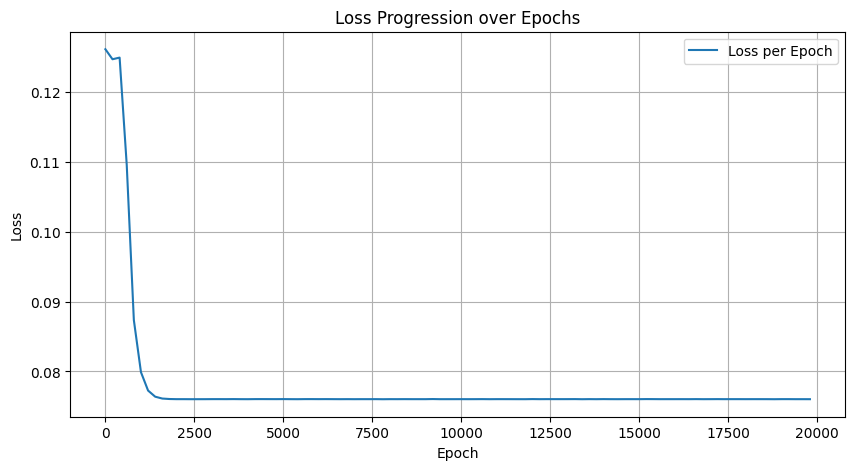

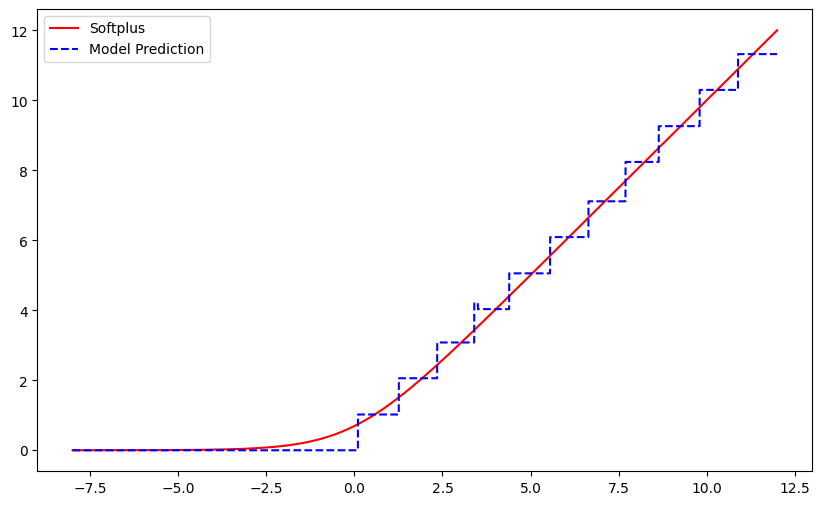

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

K=8

Epoch 1/20000, Loss: 0.007474224083125591
Epoch 1001/20000, Loss: 0.005869443528354168
Epoch 2001/20000, Loss: 0.00581616023555398
Epoch 3001/20000, Loss: 0.005817422643303871
Epoch 4001/20000, Loss: 0.005816437304019928
Epoch 5001/20000, Loss: 0.005817382130771875
Epoch 6001/20000, Loss: 0.005816556513309479
Epoch 7001/20000, Loss: 0.005816963966935873
Epoch 8001/20000, Loss: 0.005817465949803591
Epoch 9001/20000, Loss: 0.005817648954689503
Epoch 10001/20000, Loss: 0.005817132070660591
Epoch 11001/20000, Loss: 0.005818056408315897
Epoch 12001/20000, Loss: 0.005816392134875059
Epoch 13001/20000, Loss: 0.005816549062728882
Epoch 14001/20000, Loss: 0.005817567929625511
Epoch 15001/20000, Loss: 0.005816541612148285
Epoch 16001/20000, Loss: 0.005816932301968336
Epoch 17001/20000, Loss: 0.005816555116325617
Epoch 18001/20000, Loss: 0.0058166468515992165
Epoch 19001/20000, Loss: 0.005817429628223181
Loss values: [0.007474224083125591, 0.005958388559520245, 0.005828489549458027, 0.00588251044

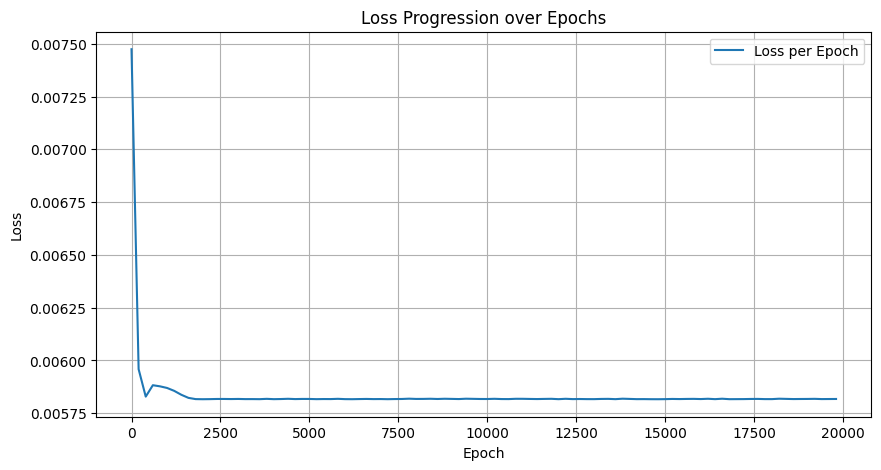

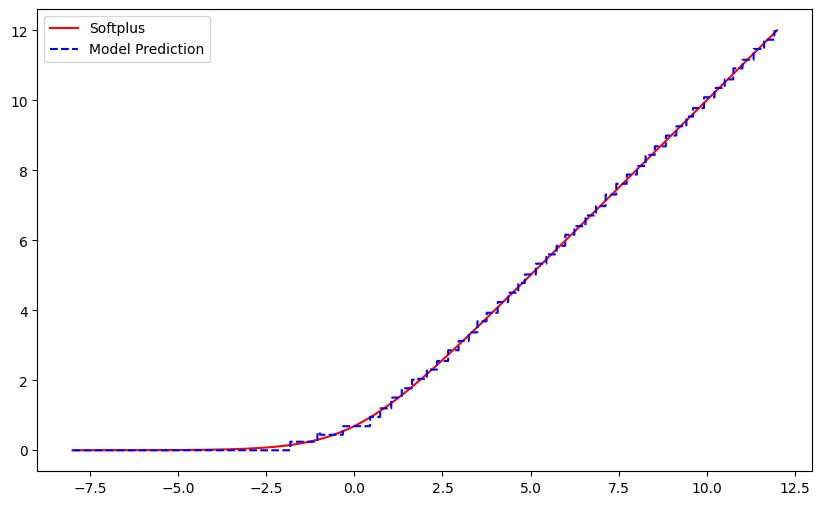

In [5]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

K=12

Epoch 1/20000, Loss: 0.007239211350679398
Epoch 1001/20000, Loss: 0.0022128289565443993
Epoch 2001/20000, Loss: 0.002204671734943986
Epoch 3001/20000, Loss: 0.002204024000093341
Epoch 4001/20000, Loss: 0.0022074587177485228
Epoch 5001/20000, Loss: 0.002210685983300209
Epoch 6001/20000, Loss: 0.002215042943134904
Epoch 7001/20000, Loss: 0.002217851346358657
Epoch 8001/20000, Loss: 0.0022212855983525515
Epoch 9001/20000, Loss: 0.00222486793063581
Epoch 10001/20000, Loss: 0.0022278232499957085
Epoch 11001/20000, Loss: 0.0022317864932119846
Epoch 12001/20000, Loss: 0.002234803745523095
Epoch 13001/20000, Loss: 0.0022371551021933556
Epoch 14001/20000, Loss: 0.0022410661913454533
Epoch 15001/20000, Loss: 0.002244663657620549
Epoch 16001/20000, Loss: 0.0022464198991656303
Epoch 17001/20000, Loss: 0.0022495342418551445
Epoch 18001/20000, Loss: 0.0022521812934428453
Epoch 19001/20000, Loss: 0.0022548125125467777
Loss values: [0.007239211350679398, 0.002423717873170972, 0.0023008855059742928, 0.

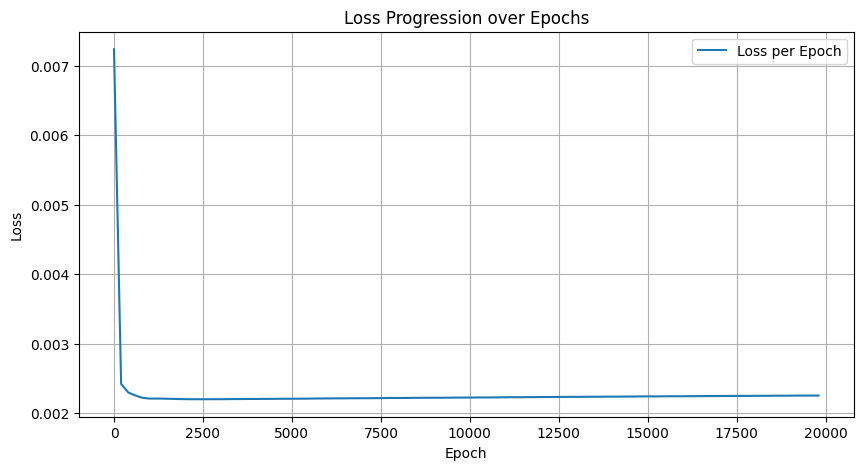

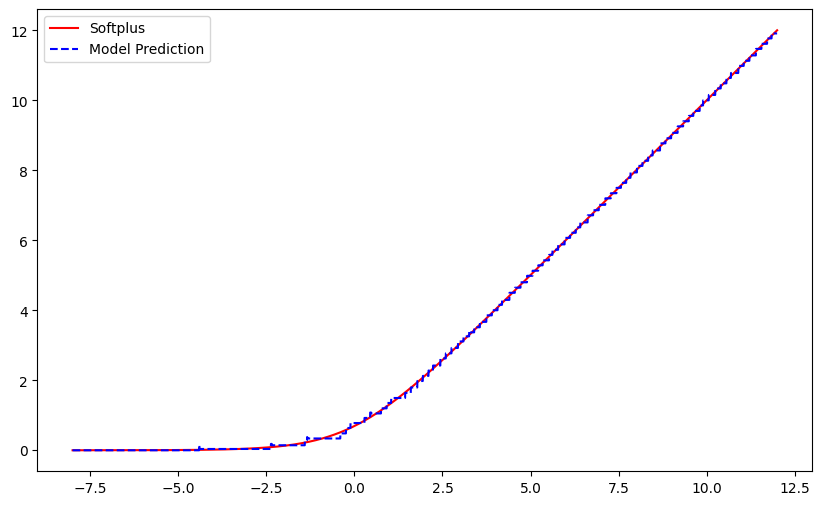

In [6]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.007919195108115673
Epoch 1001/20000, Loss: 0.0006997680757194757
Epoch 2001/20000, Loss: 0.0009072419488802552
Epoch 3001/20000, Loss: 0.0006863476592116058
Epoch 4001/20000, Loss: 0.0006946159992367029
Epoch 5001/20000, Loss: 0.0006753052002750337
Epoch 6001/20000, Loss: 0.000719896168448031
Epoch 7001/20000, Loss: 0.0006778640672564507
Epoch 8001/20000, Loss: 0.0008302662754431367
Epoch 9001/20000, Loss: 0.0008114213705994189
Epoch 10001/20000, Loss: 0.0008751293062232435
Epoch 11001/20000, Loss: 0.0008740018238313496
Epoch 12001/20000, Loss: 0.0007489252602681518
Epoch 13001/20000, Loss: 0.0007801827741786838
Epoch 14001/20000, Loss: 0.0010389392264187336
Epoch 15001/20000, Loss: 0.0007744698086753488
Epoch 16001/20000, Loss: 0.0008570329518988729
Epoch 17001/20000, Loss: 0.0008154723327606916
Epoch 18001/20000, Loss: 0.0007744304602965713
Epoch 19001/20000, Loss: 0.0007857572054490447
Loss values: [0.007919195108115673, 0.0012099925661459565, 0.00100785505492

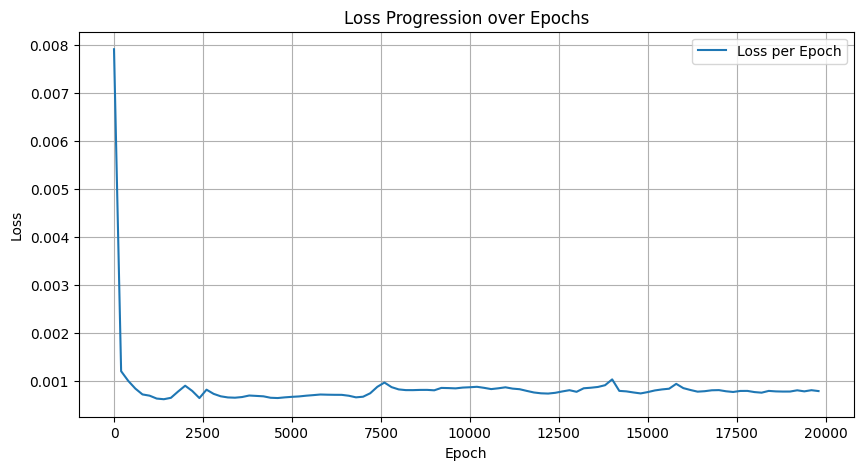

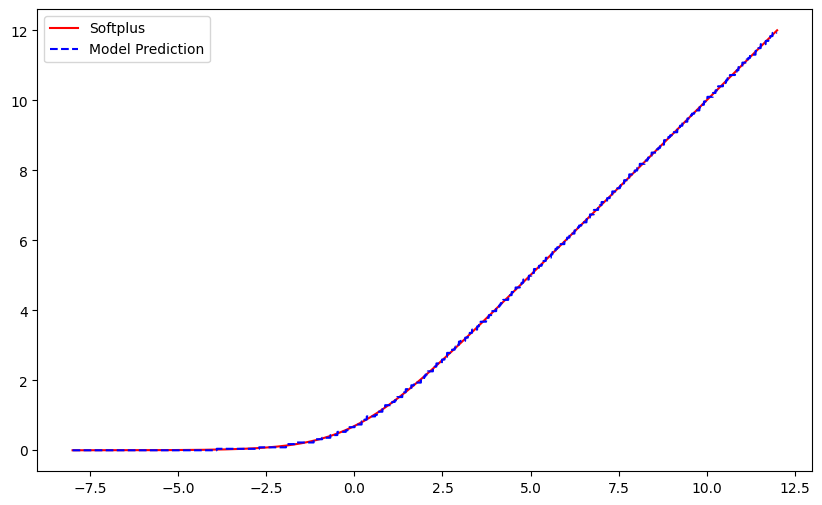

In [11]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()